In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import keras
import tensorflow
from tensorflow.keras import datasets
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras import applications

2024-05-12 11:01:38.859509: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-12 11:01:38.859646: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-12 11:01:38.976509: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [3]:
train_images[1].shape

(28, 28)

In [4]:
bat_size = 32
image_size = 28
image_channel = 1

In [5]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
train_labels_ohe = enc.fit_transform(train_labels.reshape(-1, 1)).toarray().astype(int)
test_labels_ohe = enc.transform(test_labels.reshape(-1, 1)).toarray().astype(int)

In [6]:
from sklearn.model_selection import train_test_split 
x_te, x_val, y_te, y_val = train_test_split(test_images, test_labels_ohe, test_size=0.3, random_state=21)

In [7]:
x_val.shape

(3000, 28, 28)

In [8]:
train_datagen = ImageDataGenerator(rescale=1./25,
                                    rotation_range = 15,
                                    horizontal_flip = True,
                                    zoom_range = 0.2,
                                    shear_range = 0.1,
                                    fill_mode = 'reflect',
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1)

test_datagen = ImageDataGenerator(rescale=1./25)

In [9]:
upscaled_image = cv2.resize(train_images.shape[1:], (32, 32), interpolation=cv2.INTER_LINEAR)

upscaled_image.shape

(32, 32)

In [10]:
upscaled_train_images = []
for image in train_images:
    upscaled_image_train_images = cv2.resize(image, (32, 32), interpolation=cv2.INTER_LINEAR)
    upscaled_train_images.append(upscaled_image_train_images)
    

upscaled_x_val = []
for image in x_val:
    upscaled_image_x_val = cv2.resize(image, (32, 32), interpolation=cv2.INTER_LINEAR)
    upscaled_x_val.append(upscaled_image_x_val)
    
    

upscaled_x_te = []
for image in x_te:
    upscaled_image_x_te = cv2.resize(image, (32, 32), interpolation=cv2.INTER_LINEAR)
    upscaled_x_te.append(upscaled_image_x_te)

upscaled_train_images = np.array(upscaled_train_images)
upscaled_x_val = np.array(upscaled_x_val)
upscaled_x_te = np.array(upscaled_x_te)


In [11]:
train_images = upscaled_train_images.reshape((-1, 32, 32, 1))
x_val = upscaled_x_val.reshape((-1, 32, 32, 1))
x_te  = upscaled_x_te.reshape((-1, 32, 32, 1))

In [12]:
train_images[20000:40000].shape

(20000, 32, 32, 1)

In [13]:
x_te.shape, y_te.shape

((7000, 32, 32, 1), (7000, 10))

In [14]:
test_generator = test_datagen.flow(x_te,  y_te,
                                                  batch_size = bat_size,
                                                  shuffle=False
                                                 )

In [15]:
train_generator_resnet = train_datagen.flow(train_images[:20000], train_labels_ohe[:20000],
                                                    batch_size = bat_size
                                                   )
val_generator_resnet = test_datagen.flow(x_val[:1000],  y_val[:1000],
                                                 batch_size = bat_size,
                                                 shuffle=False
                                                )

In [16]:
train_generator_desnet = train_datagen.flow(train_images[20000:40000], train_labels_ohe[20000:40000],
                                                    batch_size = bat_size
                                                   )
val_generator_desnet = test_datagen.flow(x_val[1000:2000],  y_val[1000:2000],
                                                 batch_size = bat_size,
                                                 shuffle=False
                                                )

In [17]:
train_generator_mobilenet = train_datagen.flow(train_images[40000:], train_labels_ohe[40000:],
                                                    batch_size = bat_size
                                                   )
val_generator_mobilenet = test_datagen.flow(x_val[2000:],  y_val[2000:],
                                                 batch_size = bat_size,
                                                 shuffle=False
                                                )

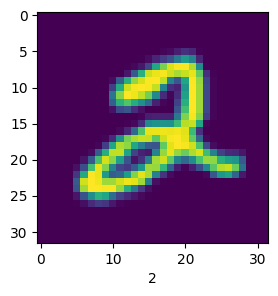

In [18]:
fig, ax = plt.subplots(figsize=(3, 3))
plt.imshow(train_images[5])
plt.xlabel(train_labels[5])
plt.show()

In [19]:
train_images.shape

(60000, 32, 32, 1)

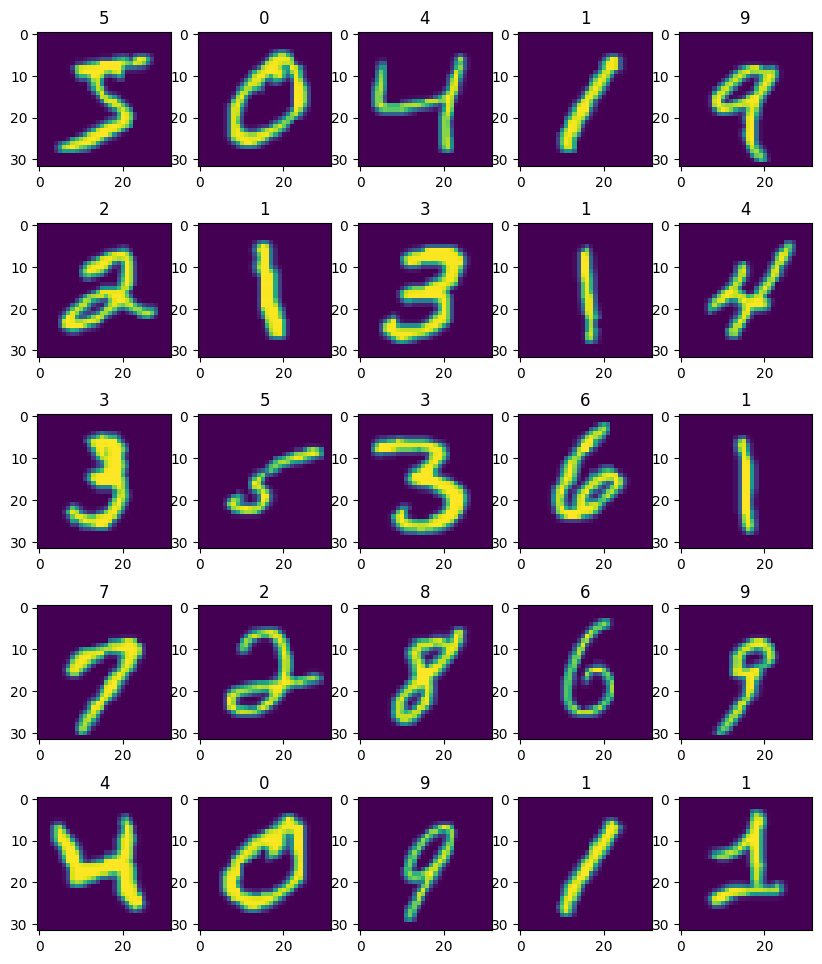

In [20]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(5, 5, figsize=(10, 12))
for i in range(25):
    ax[i // 5, i % 5].imshow(train_images[i])
    ax[i // 5, i % 5].set_title(train_labels[i])

In [30]:
from tensorflow.keras import applications

resnet = applications.ResNet101(
    include_top=True,
    weights= None,
    input_tensor=None,
    input_shape= train_images.shape[1:],
    classes=10,
    classifier_activation='softmax'
)

In [31]:
resnet.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [32]:
history_resnet = resnet.fit(train_generator_resnet, epochs=10, batch_size=32, validation_data = val_generator_resnet)

Epoch 1/10
  3/625 ━━━━━━━━━━━━━━━━━━━━ 41s 67ms/step - acc: 0.0764 - loss: 4.6360    

W0000 00:00:1715512750.001865     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - acc: 0.3641 - loss: 2.3838

W0000 00:00:1715512794.437556     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


625/625 ━━━━━━━━━━━━━━━━━━━━ 151s 77ms/step - acc: 0.3643 - loss: 2.3828 - val_acc: 0.3670 - val_loss: 2.1457
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - acc: 0.7610 - loss: 0.7891 - val_acc: 0.2420 - val_loss: 4.7954
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - acc: 0.7371 - loss: 1.0180 - val_acc: 0.9170 - val_loss: 0.2704
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - acc: 0.8863 - loss: 0.3777 - val_acc: 0.6520 - val_loss: 1.4691
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - acc: 0.8623 - loss: 0.5367 - val_acc: 0.8530 - val_loss: 0.5884
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - acc: 0.9234 - loss: 0.2612 - val_acc: 0.7400 - val_loss: 1.0465
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - acc: 0.8972 - loss: 0.3970 - val_acc: 0.4410 - val_loss: 4.4021
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - acc: 0.8737 - loss: 0.4335 - val_acc: 0.8090 - val_loss: 0.5812
Epoch 9/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/s

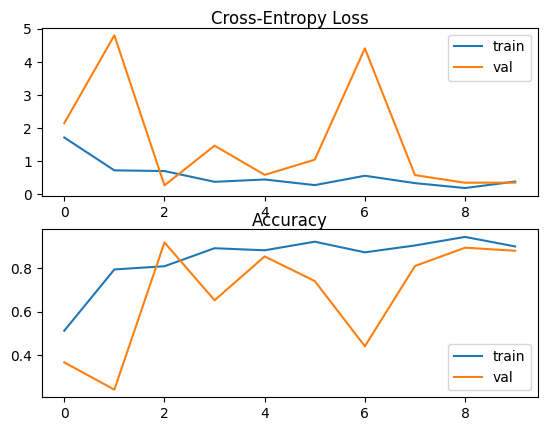

In [33]:
plt.subplot(211)
plt.title('Cross-Entropy Loss', pad=-40)
plt.plot(history_resnet.history['loss'], label='train')
plt.plot(history_resnet.history['val_loss'], label='val')
plt.legend()
# plot accuracy learning curves
plt.subplot(212)
plt.title('Accuracy', pad=-40)
plt.plot(history_resnet.history['acc'], label='train')
plt.plot(history_resnet.history['val_acc'], label='val')
plt.legend()


In [34]:
loss, acc = resnet.evaluate(test_generator)
print("resnet model, accuracy: {:5.2f}%".format(100 * acc))

219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - acc: 0.8901 - loss: 0.3562
resnet model, accuracy: 89.09%


W0000 00:00:1715513150.032663     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [35]:
desnet = applications.DenseNet121(
    include_top=True,
    weights= None,
    input_tensor=None,
    input_shape= train_images.shape[1:],
    pooling=None,
    classes=10,
    classifier_activation="softmax",
)

In [36]:
desnet.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [37]:
history_desnet = desnet.fit(train_generator_desnet, epochs=5, batch_size=32, validation_data = val_generator_desnet)

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 174s 68ms/step - acc: 0.7151 - loss: 0.8599 - val_acc: 0.8430 - val_loss: 0.5105
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 53s 39ms/step - acc: 0.9234 - loss: 0.2427 - val_acc: 0.9230 - val_loss: 0.2470
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step - acc: 0.9423 - loss: 0.1978 - val_acc: 0.8950 - val_loss: 0.3791
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - acc: 0.9527 - loss: 0.1535 - val_acc: 0.9490 - val_loss: 0.1774
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - acc: 0.9504 - loss: 0.1540 - val_acc: 0.9390 - val_loss: 0.2073


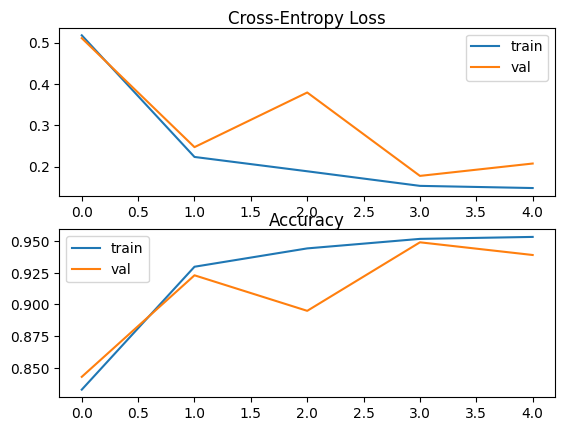

In [38]:
plt.subplot(211)
plt.title('Cross-Entropy Loss', pad=-40)
plt.plot(history_desnet.history['loss'], label='train')
plt.plot(history_desnet.history['val_loss'], label='val')
plt.legend()


plt.subplot(212)
plt.title('Accuracy', pad=-40)
plt.plot(history_desnet.history['acc'], label='train')
plt.plot(history_desnet.history['val_acc'], label='val')
plt.legend()


In [39]:
loss, acc = desnet.evaluate(test_generator)
print("desnet model, accuracy: {:5.2f}%".format(100 * acc))

219/219 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - acc: 0.9528 - loss: 0.1642
desnet model, accuracy: 95.24%


In [40]:
mobilenet = applications.MobileNet(
    input_shape=train_images.shape[1:],
    alpha=1.0,
    depth_multiplier=1,
    dropout=0.001,
    include_top=True,
    weights= None,
    input_tensor=None,
    pooling=None,
    classes=10,
    classifier_activation="softmax",
)

In [41]:
mobilenet.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [42]:
history_mobilenet = mobilenet.fit(train_generator_mobilenet, epochs=5, batch_size=32, validation_data = val_generator_mobilenet)

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 20ms/step - acc: 0.3262 - loss: 2.0289 - val_acc: 0.1100 - val_loss: 2.2818
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - acc: 0.7120 - loss: 0.8526 - val_acc: 0.8980 - val_loss: 0.3605
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - acc: 0.8209 - loss: 0.5468 - val_acc: 0.8920 - val_loss: 0.3357
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - acc: 0.8669 - loss: 0.4198 - val_acc: 0.9270 - val_loss: 0.2471
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - acc: 0.8954 - loss: 0.3389 - val_acc: 0.8490 - val_loss: 0.7581


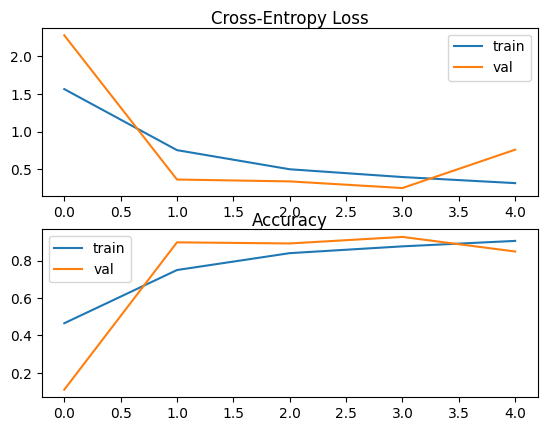

In [43]:
plt.subplot(211)
plt.title('Cross-Entropy Loss', pad=-40)
plt.plot(history_mobilenet.history['loss'], label='train')
plt.plot(history_mobilenet.history['val_loss'], label='val')
plt.legend()
# plot accuracy learning curves
plt.subplot(212)
plt.title('Accuracy', pad=-40)
plt.plot(history_mobilenet.history['acc'], label='train')
plt.plot(history_mobilenet.history['val_acc'], label='val')
plt.legend()


In [44]:
loss, acc = mobilenet.evaluate(test_generator)
print("mobilenet model, accuracy: {:5.2f}%".format(100 * acc))

219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - acc: 0.8591 - loss: 0.7300
mobilenet model, accuracy: 86.29%


In [45]:
class WeightedAverageLayer(tensorflow.keras.layers.Layer):
    def __init__(self, w1, w2, w3, **kwargs):
        super(WeightedAverageLayer, self).__init__(**kwargs)
        self.w1 = w1
        self.w2 = w2
        self.w3 = w3
        
        
    def call(self, inputs):
        return self.w1 * inputs[0] + self.w2 * inputs[1] + + self.w3 * inputs[2]

In [46]:
from tensorflow.keras import layers, Model
import itertools


models = [resnet, desnet, mobilenet]
model_input = layers.Input(shape=(32, 32, 1))
model_outputs = [model(model_input) for model in models]
flattened_outputs = list(model_outputs)
ensemble_output = layers.Average()(flattened_outputs)
ensemble_model = Model(inputs=model_input, outputs=ensemble_output)

In [47]:
ensemble_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [48]:
ensemble_model.evaluate(test_generator)

219/219 ━━━━━━━━━━━━━━━━━━━━ 39s 72ms/step - acc: 0.9679 - loss: 0.1902


[0.18817244470119476, 0.968999981880188]

In [ ]:
from tensorflow.keras.models import load_model

resnet.save('/kaggle/working/resnet_mnist_92_86.hdf5')
resnet.save('/kaggle/working/resnet_mnist_92_86.h5')

In [ ]:
desnet.save('/kaggle/working/desnet_mnist_93_03.hdf5')
desnet.save('/kaggle/working/desnet_mnist_93_03.h5')

In [ ]:
from tensorflow.keras.models import load_model

mobilenet.save('/kaggle/working/mobilenet_mnist_93_08.hdf5')
mobilenet.save('/kaggle/working/mobilenet_mnist_93_08.h5')

In [ ]:
ensemble_model.save('/kaggle/working/resemple_ensemble_1_mnist_96_05.hdf5')
ensemble_model.save('/kaggle/working/resemple_ensemble_1_mnist_96_05.h5')